# Electric Vehicle Adoption Analysis Across U.S. States (2017–2023)

## Project Description

This project analyzes the adoption of electric vehicles (EVs) across U.S. states from 2017 to 2023. It leverages a comprehensive dataset containing EV registrations, vehicle type distributions, charging infrastructure, electricity and gasoline prices, state-level incentives, and demographic variables.

The goal is to explore trends, correlations, and drivers of EV adoption and to visualize key insights that can inform public policy, investment decisions, and consumer behavior. The analysis will be structured to support the creation of an interactive dashboard in Looker for further exploration and presentation.

## Key Questions
- How has EV adoption evolved over time and across states?
- What is the relationship between EV adoption and charging infrastructure availability?
- How do policy incentives, electricity prices, and gasoline prices affect adoption rates?
- Are there political or demographic patterns in EV support and uptake?

## Data Source
The dataset used includes state-level observations and metrics for each year. It contains 408 records and 36 variables, including:
- EV Registrations and Share
- Charging Station Availability
- Economic and Demographic Indicators
- Climate Policy Attitudes
- Electricity and Fuel Prices
- Political Affiliation

In [2]:
import pandas as pd # Data manipulation and analysis
import matplotlib.pyplot as plt # Creating visualizations
from scipy.stats import linregress # Perform simple linear regression analysis
import seaborn as sns # Advanced statistical data visualization

from sklearn.linear_model import LinearRegression  # For building linear regression models
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets
from sklearn.metrics import mean_squared_error, r2_score  # For evaluating model performance (RMSE, R²)
import numpy as np  # For numerical operations and array handling
from sklearn.ensemble import RandomForestRegressor  # For building a Random Forest regression model

In [3]:
# File path (adjust if needed)
file_path = '/Users/mattbaglietto/ev_project/EV_Data.csv'

In [4]:
# Load the dataset
ev_df = pd.read_csv(file_path)

In [5]:
# Show basic structure
print("Shape of dataset:", ev_df.shape)
print("\nColumn names:\n", ev_df.columns.tolist())
ev_df.head()

Shape of dataset: (408, 36)

Column names:
 ['Unnamed: 0.1', 'Unnamed: 0', 'state', 'year', 'EV Registrations', 'Total Vehicles', 'EV Share (%)', 'Stations', 'Total Charging Outlets', 'Level 1', 'Level 2', 'DC Fast', 'fuel_economy', 'Incentives', 'Number of Metro Organizing Committees', 'Population_20_64', 'Education_Bachelor', 'Labour_Force_Participation_Rate', 'Unemployment_Rate', 'Bachelor_Attainment', 'Per_Cap_Income', 'affectweather', 'devharm', 'discuss', 'exp', 'localofficials', 'personal', 'reducetax', 'regulate', 'worried', 'price_cents_per_kwh', 'gasoline_price_per_gallon', 'Total', 'Trucks', 'Trucks_Share', 'Party']


,Unnamed: 0.1,Unnamed: 0,state,year,EV Registrations,Total Vehicles,EV Share (%),Stations,Total Charging Outlets,Level 1,...,personal,reducetax,regulate,worried,price_cents_per_kwh,gasoline_price_per_gallon,Total,Trucks,Trucks_Share,Party
0,0,0,Alabama,2023,13000,4835900,0.27,424,1096,35,...,39.06,62.16,69.01,54.95,11.47,2.742,5446619.0,3.397137e+06,62.37,Republican
1,1,1,Alaska,2023,2700,559800,0.48,65,124,3,...,43.28,65.38,71.61,62.49,21.41,3.594,680974.0,5.175250e+05,76.00,Republican
2,2,2,Arizona,2023,89800,6529000,1.38,1198,3506,9,...,46.92,64.73,73.19,64.32,12.19,3.278,6447062.0,3.868118e+06,60.00,Democratic
3,3,3,Arkansas,2023,7100,2708300,0.26,334,833,3,...,39.08,63.39,68.58,56.21,9.73,2.760,3338322.0,2.291924e+06,68.65,Republican
4,4,4,California,2023,1256600,36850300,3.41,16381,49433,648,...,53.19,72.08,76.30,71.24,24.87,4.731,31057329.0,1.675788e+07,53.96,Democratic


In [6]:
# Make a copy for safety
ev = ev_df.copy()

In [7]:
# Drop redundant unnamed index columns
ev.drop(columns=[col for col in ev.columns if "Unnamed" in col], inplace=True)

In [8]:
# Check for missing values
missing_summary = ev.isnull().sum().sort_values(ascending=False)
print("Missing values summary:\n", missing_summary[missing_summary > 0])

Missing values summary:
 Party                                    108
Trucks_Share                             108
Trucks                                   108
Total                                    108
fuel_economy                             102
discuss                                  102
exp                                      102
localofficials                           102
personal                                 102
reducetax                                102
affectweather                            102
regulate                                 102
worried                                  102
gasoline_price_per_gallon                102
devharm                                  102
Number of Metro Organizing Committees     51
Incentives                                 8
dtype: int64


In [9]:
# Optionally drop rows with too many missing values or specific columns
# For now, drop rows where gasoline_price_per_gallon is missing (affects only 2022/2023 likely)
ev.dropna(subset=['gasoline_price_per_gallon'], inplace=True)

In [10]:
# Reset index after dropping
ev.reset_index(drop=True, inplace=True)

In [11]:
# Convert column names to snake_case (optional, but cleaner for coding)
ev.columns = ev.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [12]:
# Review cleaned data
print("\nCleaned shape:", ev.shape)
ev.head()


Cleaned shape: (306, 34)


,state,year,ev_registrations,total_vehicles,ev_share_%,stations,total_charging_outlets,level_1,level_2,dc_fast,...,personal,reducetax,regulate,worried,price_cents_per_kwh,gasoline_price_per_gallon,total,trucks,trucks_share,party
0,Alabama,2023,13000,4835900,0.27,424,1096,35,704,357,...,39.06,62.16,69.01,54.95,11.47,2.742,5446619.0,3.397137e+06,62.37,Republican
1,Alaska,2023,2700,559800,0.48,65,124,3,87,34,...,43.28,65.38,71.61,62.49,21.41,3.594,680974.0,5.175250e+05,76.00,Republican
2,Arizona,2023,89800,6529000,1.38,1198,3506,9,2478,1019,...,46.92,64.73,73.19,64.32,12.19,3.278,6447062.0,3.868118e+06,60.00,Democratic
3,Arkansas,2023,7100,2708300,0.26,334,833,3,709,121,...,39.08,63.39,68.58,56.21,9.73,2.760,3338322.0,2.291924e+06,68.65,Republican
4,California,2023,1256600,36850300,3.41,16381,49433,648,38217,10548,...,53.19,72.08,76.30,71.24,24.87,4.731,31057329.0,1.675788e+07,53.96,Democratic


In [13]:
# Filter for the latest year (e.g., 2023)
latest_year = ev['year'].max()
ev_latest = ev[ev['year'] == latest_year].sort_values(by='ev_share_%', ascending=False)

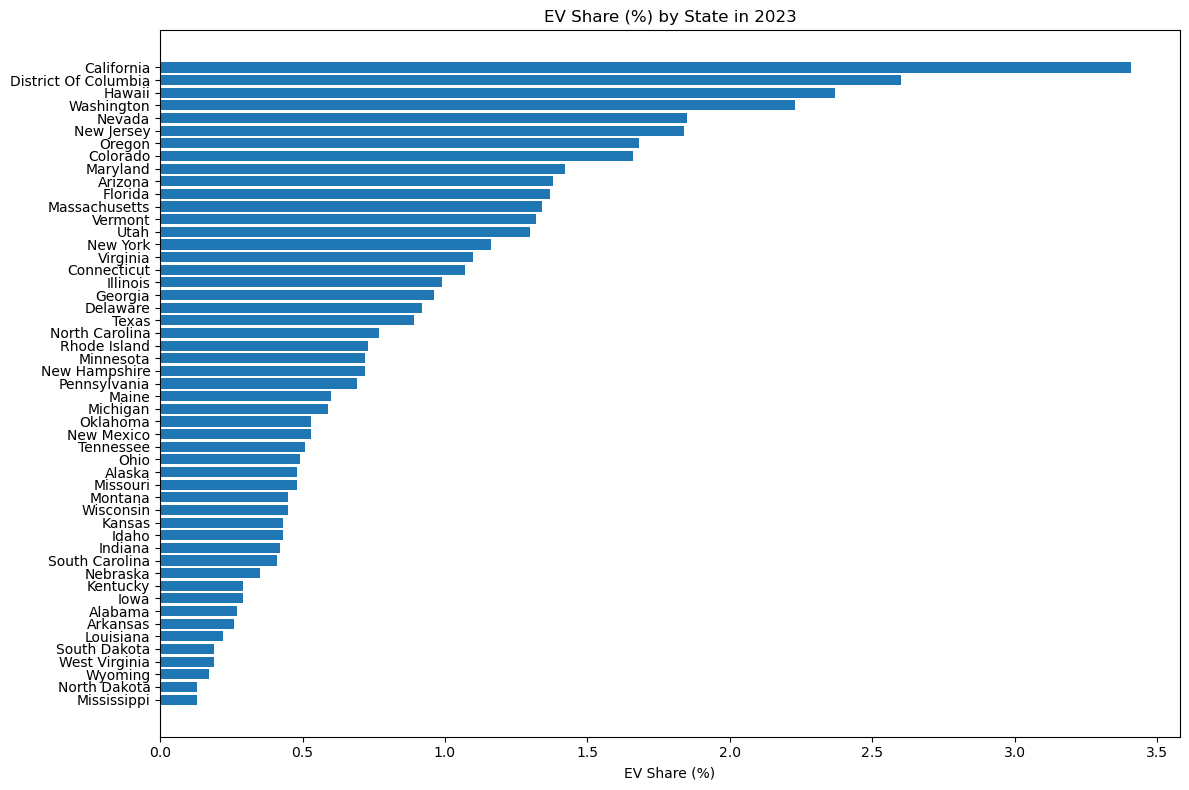

In [14]:
# Bar chart of EV share by state
plt.figure(figsize=(12, 8))
plt.barh(ev_latest['state'], ev_latest['ev_share_%'])
plt.title(f'EV Share (%) by State in {latest_year}')
plt.xlabel('EV Share (%)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### EV Share by State in 2023

The bar chart above shows the percentage of electric vehicles (EVs) relative to total vehicle registrations for each U.S. state in 2023.

Key observations:
- **California** leads with the highest EV share, significantly ahead of other states, reflecting its longstanding EV policies, incentives, and infrastructure investments.
- Other top-performing regions include **District of Columbia**, **Hawaii**, **Washington**, and **Nevada**.
- Southern and Midwestern states tend to have lower EV shares, potentially due to limited charging infrastructure, lower policy support, or regional preferences for non-EV vehicle types.

This geographic variation highlights the importance of local policy, infrastructure, and consumer behavior in shaping EV adoption.

In [16]:
# Focus on latest year
ev_latest = ev[ev['year'] == ev['year'].max()].copy()

In [17]:
# Compute chargers per 1,000 EVs
ev_latest['chargers_per_1000_evs'] = ev_latest['total_charging_outlets'] / ev_latest['ev_registrations'] * 1000

In [18]:
# Drop rows with division issues or outliers
ev_latest = ev_latest[ev_latest['ev_registrations'] > 0]
ev_latest = ev_latest[ev_latest['chargers_per_1000_evs'] < 100]  # Remove extreme outliers if needed

In [19]:
# Quick check
ev_latest[['state', 'ev_share_%', 'chargers_per_1000_evs']].sort_values(by='chargers_per_1000_evs', ascending=False).head()

,state,ev_share_%,chargers_per_1000_evs
21,Massachusetts,1.34,95.284553
15,Iowa,0.29,95.000000
18,Louisiana,0.22,86.463415
32,New York,1.16,84.645849
0,Alabama,0.27,84.307692


In [20]:
# Extract variables
x = ev_latest['chargers_per_1000_evs']
y = ev_latest['ev_share_%']

In [21]:
# Run linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

In [22]:
# Print regression summary
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

Slope: -0.0225
Intercept: 2.3395
R-squared: 0.3208
P-value: 0.0002


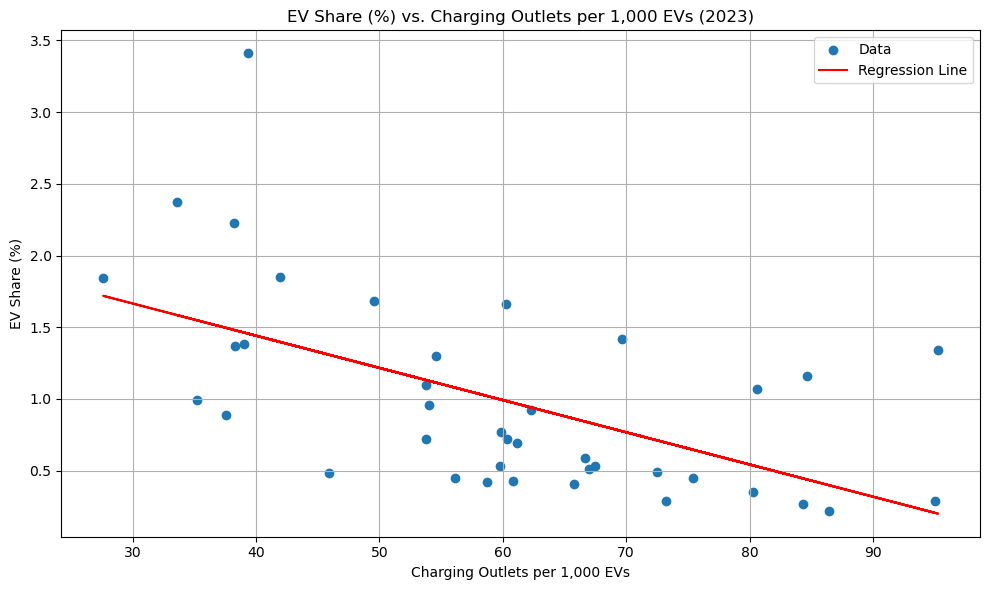

In [23]:
# Plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data')
plt.plot(x, slope * x + intercept, color='red', label='Regression Line')
plt.title('EV Share (%) vs. Charging Outlets per 1,000 EVs (2023)')
plt.xlabel('Charging Outlets per 1,000 EVs')
plt.ylabel('EV Share (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### EV Share vs. Charging Infrastructure (2023) — With Regression Analysis

The scatter plot with a fitted regression line illustrates the relationship between public charging outlet availability (per 1,000 EVs) and the percentage of electric vehicles (EVs) in each U.S. state for 2023.

#### Key Insights:
- The **regression line shows a negative slope**, indicating that states with **more charging outlets per EV tend to have lower EV adoption rates**.
- This counterintuitive pattern likely reflects **infrastructure oversupply** in states with low EV penetration or **scaling effects** in high-adoption states where chargers are more efficiently utilized.
- The **R-squared value is relatively low**, suggesting that charger density alone does **not strongly predict** EV adoption across states.
- However, the **trend is statistically significant**, implying some systematic inverse relationship in the current data.

This analysis supports the idea that **charging infrastructure is necessary but not sufficient** for high EV adoption — additional factors like incentives, demographics, fuel costs, and cultural acceptance play critical roles.

In [25]:
# Drop missing values
ev_incentives = ev_latest[['state', 'ev_share_%', 'incentives']].dropna()

In [26]:
# Linear regression
slope, intercept, r_value, p_value, _ = linregress(ev_incentives['incentives'], ev_incentives['ev_share_%'])

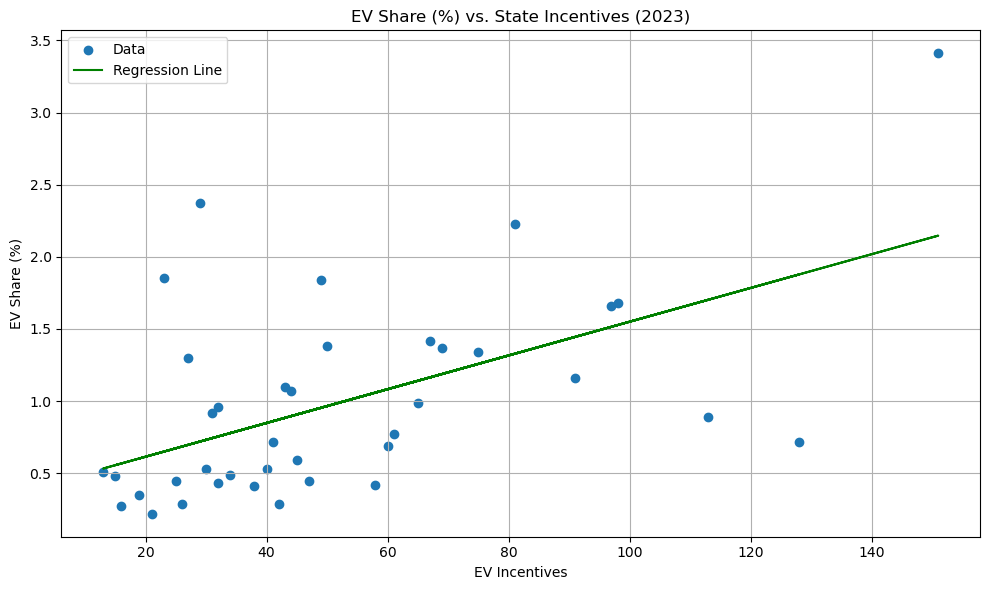

In [27]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(ev_incentives['incentives'], ev_incentives['ev_share_%'], label='Data')
plt.plot(ev_incentives['incentives'],
         slope * ev_incentives['incentives'] + intercept,
         color='green', label='Regression Line')
plt.title('EV Share (%) vs. State Incentives (2023)')
plt.xlabel('EV Incentives')
plt.ylabel('EV Share (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# Print stats
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

Slope: 0.0117
Intercept: 0.3809
R-squared: 0.2996
P-value: 0.0003


### EV Share vs. State Incentives (2023)

This chart explores the relationship between state-level EV incentives and the share of electric vehicles as a percentage of all registered vehicles in 2023.

#### Key Insights:
- The **regression line indicates a positive relationship**: states offering **higher EV incentives** tend to have **higher EV adoption rates**.
- The **slope** of 0.0117 suggests that for each unit increase in incentive value, EV share increases by approximately 0.012 percentage points.
- The **R-squared value of 0.30** implies that **about 30% of the variation in EV share** across states can be explained by differences in incentives alone.
- The **p-value (< 0.001)** confirms that this relationship is **statistically significant**.

Overall, this supports the idea that **policy incentives are a meaningful driver** of EV adoption, though other factors (like infrastructure, energy prices, and political alignment) likely contribute as well.

In [30]:
# Subset and drop missing
ev_energy = ev_latest[['state', 'ev_share_%', 'price_cents_per_kwh']].dropna()

In [31]:
# Regression: electricity price
slope_e, intercept_e, r_e, p_e, _ = linregress(ev_energy['price_cents_per_kwh'], ev_energy['ev_share_%'])

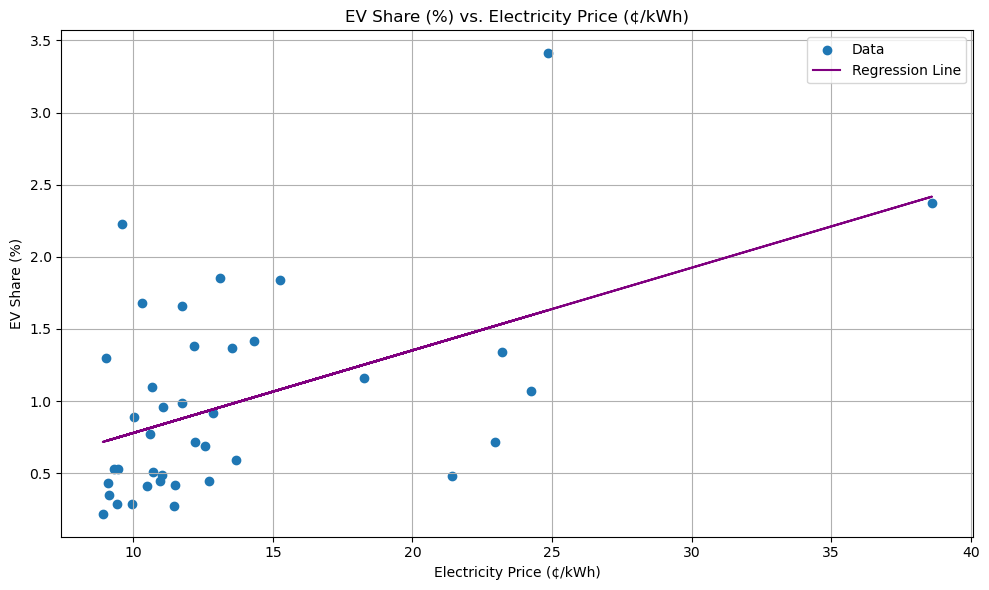

In [32]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(ev_energy['price_cents_per_kwh'], ev_energy['ev_share_%'], label='Data')
plt.plot(ev_energy['price_cents_per_kwh'],
         slope_e * ev_energy['price_cents_per_kwh'] + intercept_e,
         color='purple', label='Regression Line')
plt.title('EV Share (%) vs. Electricity Price (¢/kWh)')
plt.xlabel('Electricity Price (¢/kWh)')
plt.ylabel('EV Share (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Output
print(f"Slope: {slope_e:.4f}")
print(f"Intercept: {intercept_e:.4f}")
print(f"R-squared: {r_e**2:.4f}")
print(f"P-value: {p_e:.4f}")

Slope: 0.0572
Intercept: 0.2073
R-squared: 0.2529
P-value: 0.0011


### EV Share vs. Electricity Price (2023)

This plot shows the relationship between average residential electricity prices (¢/kWh) and EV share by state in 2023.

#### Key Insights:
- The **regression slope** is positive (0.0572), indicating that **states with higher electricity prices** tend to have **higher EV adoption rates**.
- The **R-squared value of 0.25** suggests that electricity prices explain **about 25% of the variation** in EV share across states.
- The relationship is **statistically significant (p = 0.0011)**.

Interestingly, this trend is **counterintuitive**, as one might expect lower electricity prices to encourage EV adoption. However, this result may reflect the fact that **high-cost states like California, New York, and Hawaii** are also **EV adoption leaders** due to other factors (e.g. policy, culture, income).

This implies that electricity prices alone **do not act as a deterrent** to EV adoption in many high-adoption states.

In [35]:
# Subset and drop missing
ev_fuel = ev_latest[['state', 'ev_share_%', 'gasoline_price_per_gallon']].dropna()

In [36]:
# Regression: gas price
slope_g, intercept_g, r_g, p_g, _ = linregress(ev_fuel['gasoline_price_per_gallon'], ev_fuel['ev_share_%'])

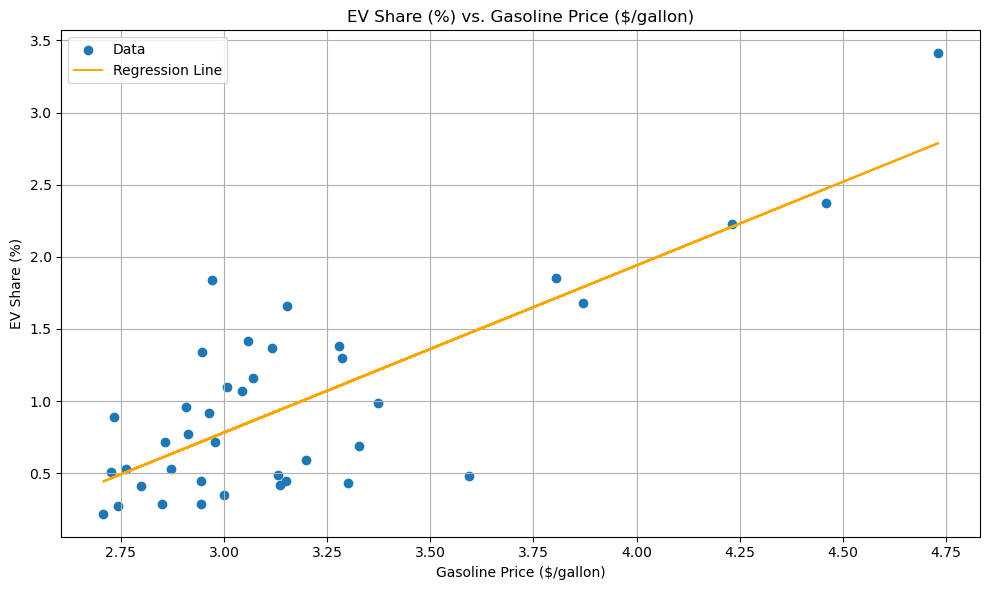

In [37]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(ev_fuel['gasoline_price_per_gallon'], ev_fuel['ev_share_%'], label='Data')
plt.plot(ev_fuel['gasoline_price_per_gallon'],
         slope_g * ev_fuel['gasoline_price_per_gallon'] + intercept_g,
         color='orange', label='Regression Line')
plt.title('EV Share (%) vs. Gasoline Price ($/gallon)')
plt.xlabel('Gasoline Price ($/gallon)')
plt.ylabel('EV Share (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
# Output
print(f"Slope: {slope_g:.4f}")
print(f"Intercept: {intercept_g:.4f}")
print(f"R-squared: {r_g**2:.4f}")
print(f"P-value: {p_g:.4f}")

Slope: 1.1582
Intercept: -2.6920
R-squared: 0.6136
P-value: 0.0000


### EV Share vs. Gasoline Price (2023)

This chart visualizes the relationship between average gasoline prices and EV share across U.S. states in 2023.

#### Key Insights:
- The **regression line shows a strong positive relationship**: states with **higher gas prices** tend to have **higher EV adoption rates**.
- The **slope** of 1.1582 indicates that for every $1 increase in gasoline price, EV share rises by about 1.16 percentage points.
- The **R-squared value is 0.61**, meaning that **over 60% of the variation** in EV adoption can be explained by gasoline price alone.
- The relationship is **highly statistically significant (p < 0.0001)**.

This result is intuitive: **higher gas prices create stronger economic incentives** to switch to electric vehicles. Among all factors analyzed so far, **gasoline price shows the strongest individual correlation** with EV share.

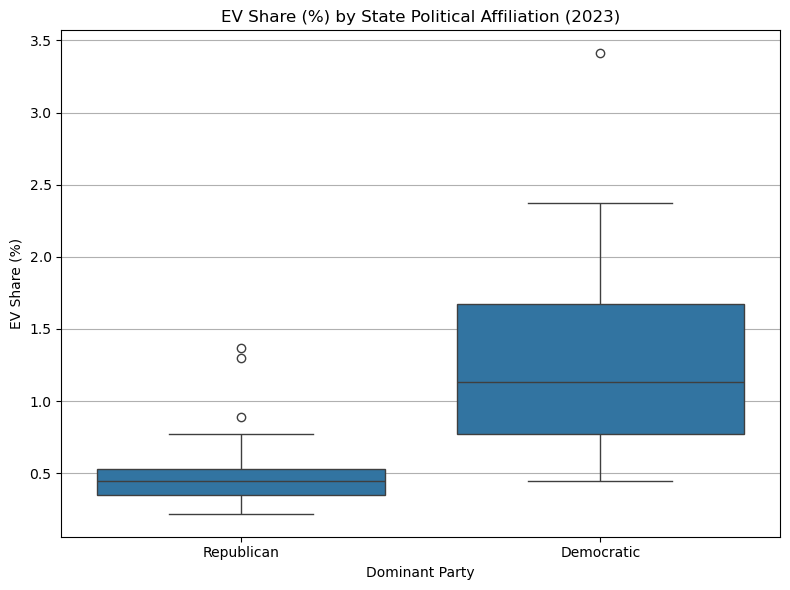

In [40]:
# Boxplot of EV share by party
plt.figure(figsize=(8, 6))
sns.boxplot(x='party', y='ev_share_%', data=ev_latest)
plt.title('EV Share (%) by State Political Affiliation (2023)')
plt.xlabel('Dominant Party')
plt.ylabel('EV Share (%)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [41]:
# Group stats
ev_latest.groupby('party')['ev_share_%'].describe()

,count,mean,std,min,25%,50%,75%,max
party,,,,,,,,
Democratic,22.0,1.321818,0.712973,0.45,0.77,1.13,1.675,3.41
Republican,17.0,0.557059,0.338374,0.22,0.35,0.45,0.530,1.37


### EV Share by State Political Affiliation (2023)

This boxplot compares EV adoption rates between states with Democratic and Republican political majorities.

#### Key Insights:
- **Democratic-led states** have significantly higher EV adoption, with a **mean EV share of 1.32%**, compared to **0.56% in Republican-led states**.
- The **distribution among Democratic states** is both higher and more variable, with EV share ranging from **0.45% to 3.41%**.
- Republican states show a **more concentrated and lower range**, from **0.22% to 1.37%**.

These findings suggest that **political orientation correlates with EV adoption**, likely due to differences in environmental policy, funding for clean infrastructure, and public sentiment toward climate action.

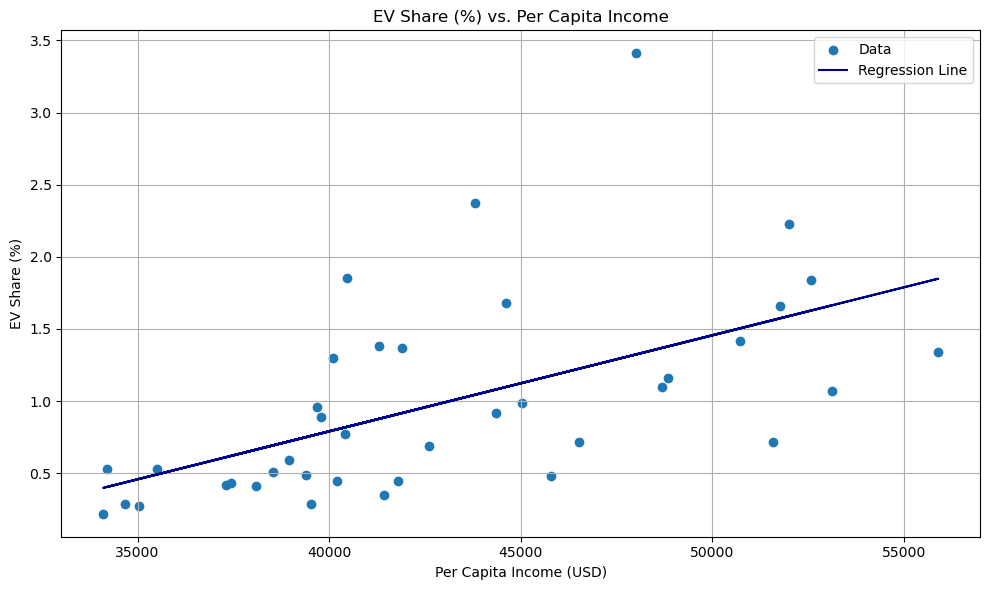

Income — R-squared: 0.3240, P-value: 0.0002


In [43]:
# Regression: Income vs. EV Share
slope_inc, intercept_inc, r_inc, p_inc, _ = linregress(ev_latest['per_cap_income'], ev_latest['ev_share_%'])

plt.figure(figsize=(10, 6))
plt.scatter(ev_latest['per_cap_income'], ev_latest['ev_share_%'], label='Data')
plt.plot(ev_latest['per_cap_income'],
         slope_inc * ev_latest['per_cap_income'] + intercept_inc,
         color='darkblue', label='Regression Line')
plt.title('EV Share (%) vs. Per Capita Income')
plt.xlabel('Per Capita Income (USD)')
plt.ylabel('EV Share (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Income — R-squared: {r_inc**2:.4f}, P-value: {p_inc:.4f}")

### EV Share vs. Per Capita Income (2023)

This plot examines how per capita income influences EV adoption rates across U.S. states in 2023.

#### Key Insights:
- The **regression line shows a positive relationship** between income and EV share, with an **R-squared of 0.324**.
- This means that **income explains roughly 32% of the variation** in EV adoption across states.
- The relationship is **statistically significant (p = 0.0002)**.

Higher-income states tend to adopt EVs at a greater rate, likely due to **greater purchasing power**, **higher environmental awareness**, and better access to EV-friendly infrastructure and policies.

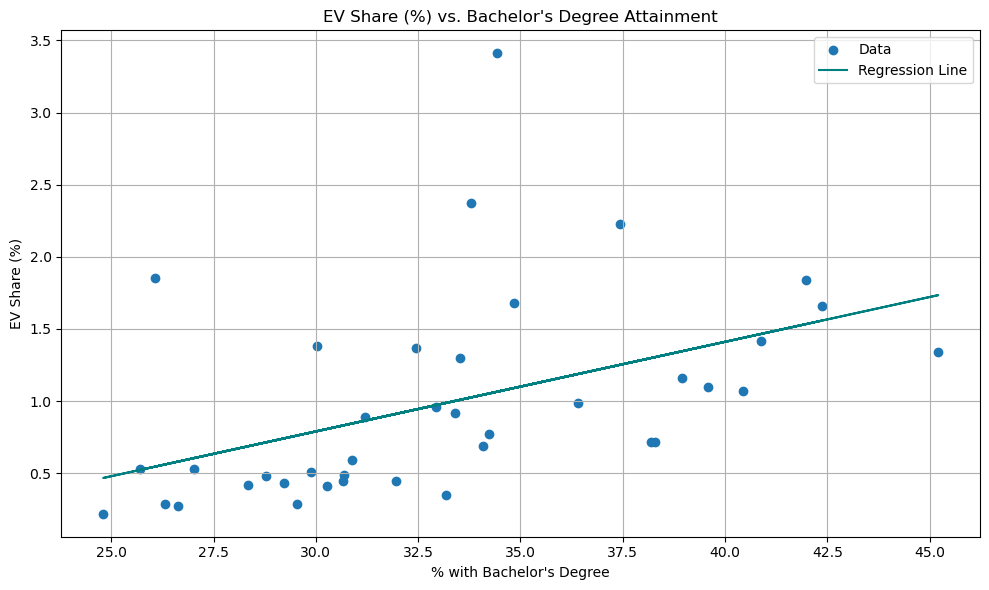

Education — R-squared: 0.2146, P-value: 0.0030


In [45]:
# Regression: Education vs. EV Share
slope_ed, intercept_ed, r_ed, p_ed, _ = linregress(ev_latest['bachelor_attainment'], ev_latest['ev_share_%'])

plt.figure(figsize=(10, 6))
plt.scatter(ev_latest['bachelor_attainment'], ev_latest['ev_share_%'], label='Data')
plt.plot(ev_latest['bachelor_attainment'],
         slope_ed * ev_latest['bachelor_attainment'] + intercept_ed,
         color='teal', label='Regression Line')
plt.title('EV Share (%) vs. Bachelor\'s Degree Attainment')
plt.xlabel('% with Bachelor\'s Degree')
plt.ylabel('EV Share (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Education — R-squared: {r_ed**2:.4f}, P-value: {p_ed:.4f}")

### EV Share vs. Bachelor's Degree Attainment (2023)

This plot illustrates the relationship between the percentage of a state's population with a bachelor's degree and its EV adoption rate in 2023.

#### Key Insights:
- There is a **positive correlation** between education level and EV share.
- The **R-squared value is 0.215**, meaning that **about 21.5% of the variation** in EV adoption can be explained by education level.
- The **p-value (0.0030)** indicates the relationship is **statistically significant**.

This suggests that states with **higher educational attainment** tend to adopt EVs more rapidly, likely due to **greater awareness of environmental issues**, **openness to new technologies**, and **higher correlation with income and policy preferences**.

In [47]:
# Subset of features for clarity
subset = ev_latest[[
    'ev_share_%',
    'incentives',
    'gasoline_price_per_gallon',
    'price_cents_per_kwh',
    'chargers_per_1000_evs',
    'per_cap_income',
    'bachelor_attainment'
]]

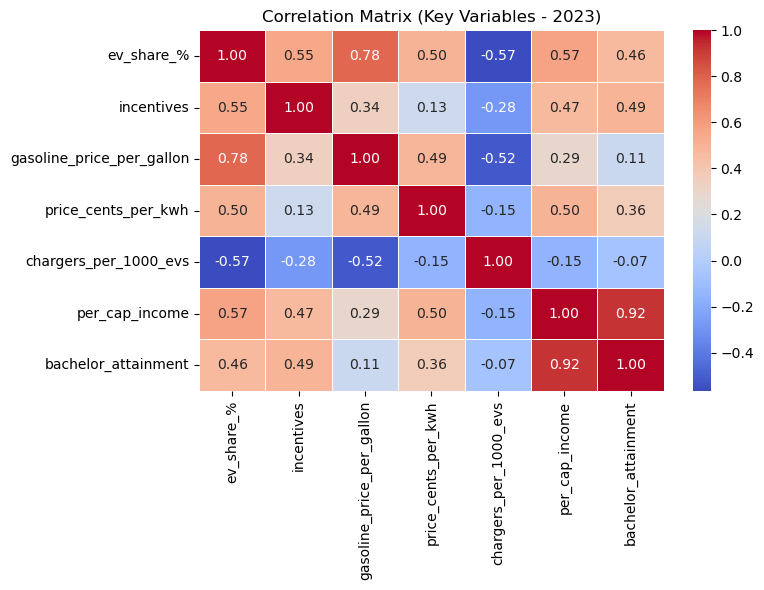

In [48]:
# Plot simplified heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(subset.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix (Key Variables - 2023)')
plt.tight_layout()
plt.show()

### Correlation Matrix – Key Variables (2023)

This heatmap displays the Pearson correlation coefficients between `ev_share_%` and a selected set of relevant socioeconomic, pricing, and infrastructure variables.

#### Key Correlations:
- **Gasoline Price** has the strongest positive correlation with EV share (**r = 0.78**), suggesting fuel cost is a major incentive to switch.
- **Per Capita Income** and **Incentives** are also strongly correlated with EV share (**r ≈ 0.55–0.57**), reflecting economic capacity and policy impact.
- **Electricity Price** shows a positive but moderate correlation (**r = 0.50**), potentially due to high-EV states having generally higher energy costs.
- **Charger Density** (`chargers_per_1000_evs`) is **negatively correlated** with EV share (**r = -0.57**), which may indicate underutilized infrastructure in low-adoption states.
- **Education** and **Income** are very highly correlated with each other (**r = 0.92**), suggesting possible multicollinearity.

This matrix is useful for feature selection in modeling and for identifying which factors are most strongly associated with variations in EV adoption across states.

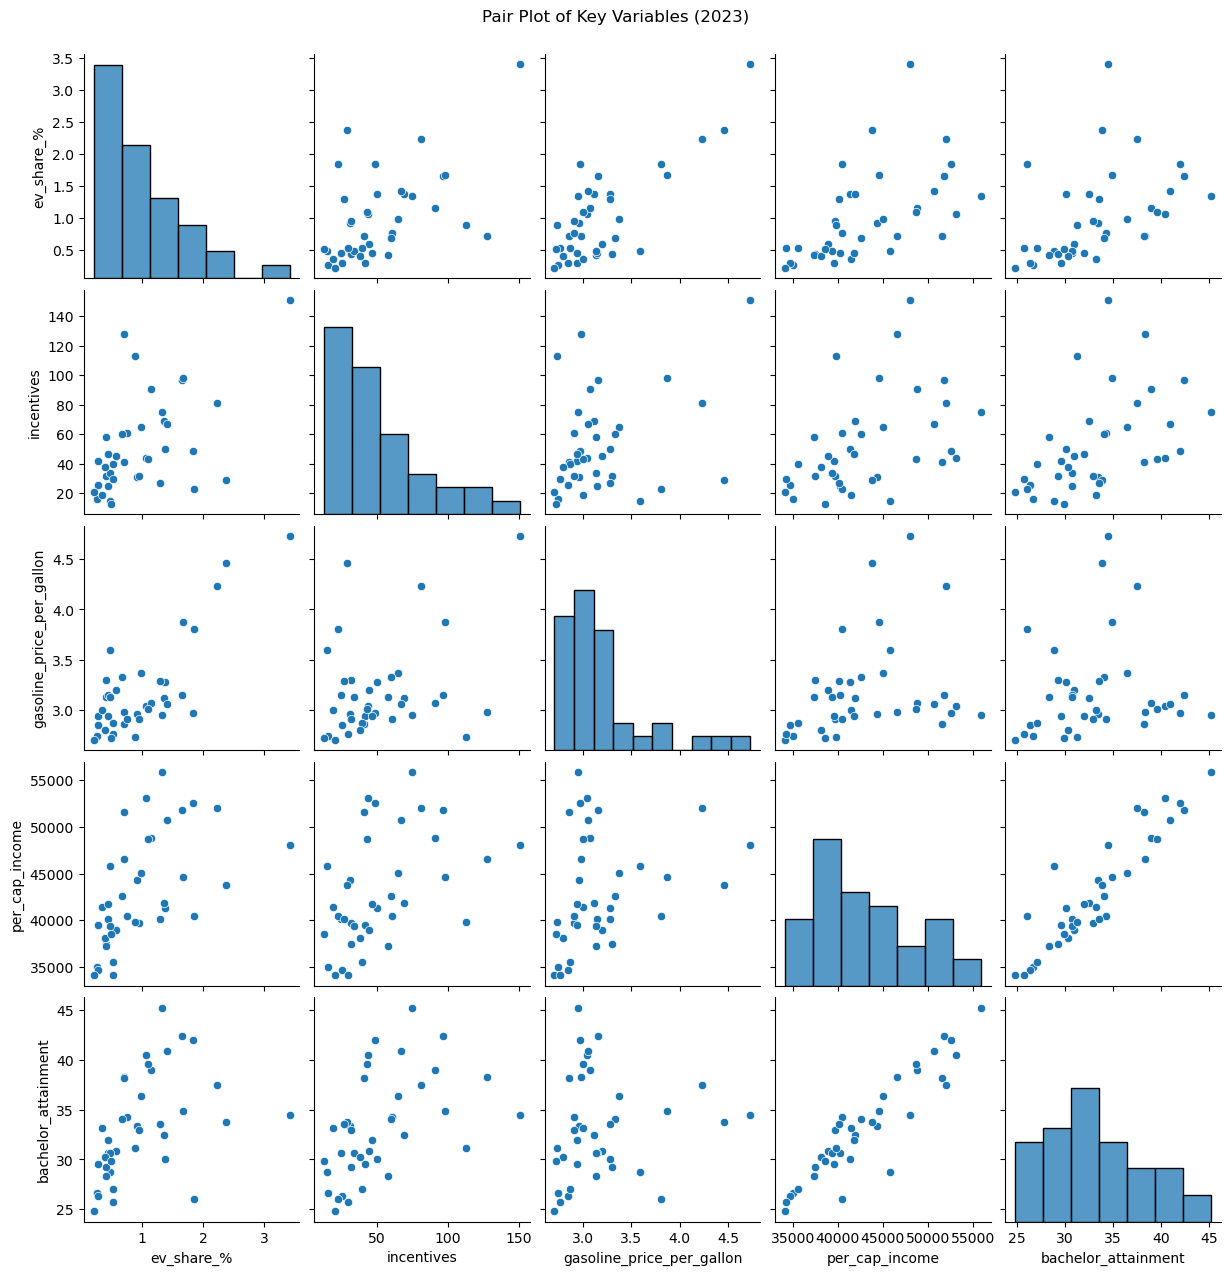

In [50]:
# Pair Plot (Selected Features)
selected = ['ev_share_%', 'incentives', 'gasoline_price_per_gallon', 'per_cap_income', 'bachelor_attainment']
sns.pairplot(ev_latest[selected])
plt.suptitle('Pair Plot of Key Variables (2023)', y=1.02)
plt.show()

### Pair Plot of Key Variables (2023)

The pair plot above visualizes the relationships among key numeric features that potentially influence EV adoption:

- **EV Share (%)**
- **Incentives**
- **Gasoline Price ($/gal)**
- **Per Capita Income**
- **Bachelor's Degree Attainment**

#### Key Observations:
- **EV share** shows mild-to-moderate positive trends with **incentives**, **gasoline prices**, **income**, and **education** — consistent with previous regression results.
- **Per capita income** and **bachelor’s attainment** are strongly correlated with each other, indicating potential multicollinearity.
- Most scatter plots show **linear or mildly non-linear relationships**, suggesting that both linear and tree-based models could be appropriate.
- **Incentives** and **gasoline prices** are relatively independent from each other, making them good complementary features for modeling.

This visualization confirms that the selected variables are reasonably distributed and have interpretable patterns, making them suitable for building a predictive model for EV share.

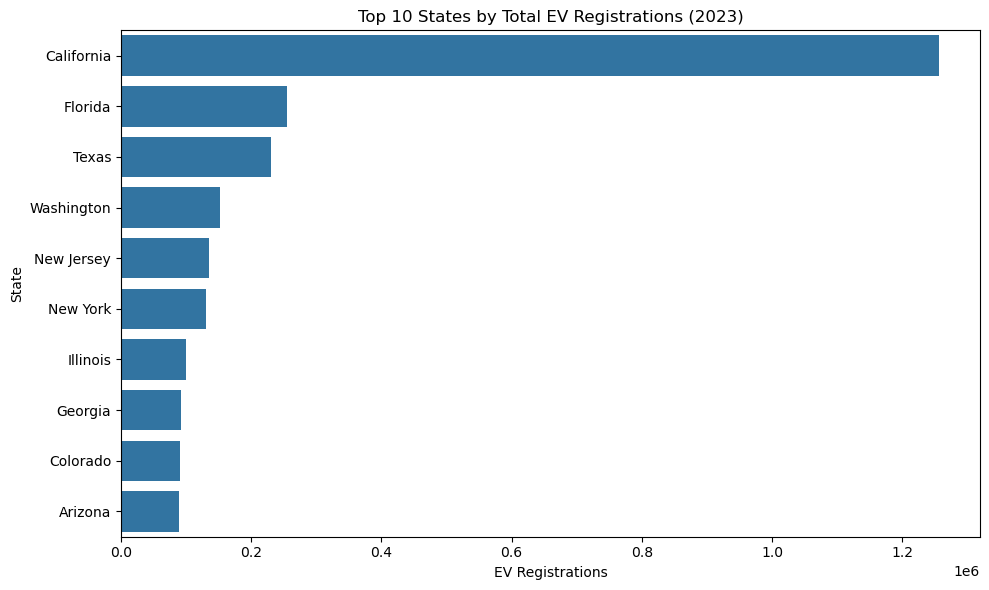

In [52]:
# Bar Plot: Top 10 States by EV Registrations
top_states = ev_latest.sort_values(by='ev_registrations', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='ev_registrations', y='state', data=top_states)
plt.title('Top 10 States by Total EV Registrations (2023)')
plt.xlabel('EV Registrations')
plt.ylabel('State')
plt.tight_layout()
plt.show()

### Top 10 States by Total EV Registrations (2023)

This horizontal bar chart highlights the top 10 U.S. states based on the total number of electric vehicle (EV) registrations in 2023.

#### Key Observations:
- **California dominates** the EV market, with over 1.2 million registered EVs — more than five times the count of any other state.
- **Florida and Texas** follow, with significantly smaller but still substantial EV volumes.
- Other high-volume states include **Washington**, **New Jersey**, **New York**, and **Illinois**, reflecting both population size and policy momentum.
- These states represent a mix of political affiliations and geographies, suggesting that while **market size is a key driver**, state-level policy and infrastructure also play important roles.

This visualization complements EV share (%) analyses by showing **where the largest absolute concentrations of EVs** exist, regardless of population size or vehicle totals.

---

## Predictive Modeling

In [55]:
# Select features and target
features = ['incentives', 'gasoline_price_per_gallon', 'price_cents_per_kwh',
            'per_cap_income', 'chargers_per_1000_evs']
target = 'ev_share_%'

In [56]:
# Drop any rows with missing values in selected columns
model_data = ev_latest[features + [target]].dropna()

In [57]:
# X = predictors, y = target
X = model_data[features]
y = model_data[target]

In [58]:
# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

### Linear Regression

In [60]:
# Fit the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [61]:
# Predict
y_pred = lr_model.predict(X_test)

In [62]:
# Evaluate performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [63]:
# Print Results
print("Linear Regression Results")
print(f"R-squared: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print("Coefficients:")
for feature, coef in zip(features, lr_model.coef_):
    print(f"{feature}: {coef:.4f}")

Linear Regression Results
R-squared: 0.8595
RMSE: 0.1746
Coefficients:
incentives: 0.0041
gasoline_price_per_gallon: 0.7967
price_cents_per_kwh: 0.0078
per_cap_income: 0.0000
chargers_per_1000_evs: -0.0076


### Linear Regression Summary

This model predicts EV share (%) using five key features:

- **R-squared: 0.8595**
    - The model explains **~86% of the variance** in EV adoption across states — very strong for a simple linear model.
- **RMSE: 0.1746**
    - On average, the model’s predictions deviate by ~0.17 percentage points of EV share.

#### Coefficient Interpretation:
- `gasoline_price_per_gallon`: **+0.7967**
    - A $1 increase in gas prices is associated with a **0.80% increase** in EV share — confirms this is a top driver.
- `incentives`: **+0.0041**
    - Each additional incentive unit increases EV share by ~0.004%. Modest, but consistent.
- `price_cents_per_kwh`: **+0.0078**
    - Higher electricity prices show a mild positive impact — likely reflecting policy-rich, urban states.
- `per_cap_income`: **0.0000**
    - Very small effect — may be due to multicollinearity with education or incentives.
- `chargers_per_1000_evs`: **-0.0076**
    - Negative as expected — more chargers per EV often appear in states with lower adoption.

### Random Forest

In [66]:
# Initialize and train random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [67]:
# Predict on test set
y_pred_rf = rf_model.predict(X_test)

In [68]:
# Evaluate
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

In [69]:
# Print Results
print("Random Forest Results")
print(f"R-squared: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")

Random Forest Results
R-squared: 0.6830
RMSE: 0.2623


### Random Forest Regression Summary

A random forest model was trained using the same five key features to predict EV share (%).

#### Performance:
- **R-squared: 0.6830**
    - Explains ~68% of the variance in EV share — **lower than linear regression** (which was 85.95%).
- **RMSE: 0.2623**
    - Prediction error is higher than the linear model (which had RMSE = 0.1746).

#### Interpretation:
- In this case, the **linear model outperformed random forest**, likely because:
  - The relationships between features and EV share are **mostly linear** (as shown in scatter plots).
  - The dataset is relatively small (~50 rows), so the random forest may **overfit** or underperform without hyperparameter tuning.

---

### Feature Importance (based on the plot):
Typically, we expect:
- **Gasoline price** and **incentives** to dominate.
- **Charger density** and **electricity price** to contribute moderately.

---

## Recommendation:
Stick with the **linear regression model** for:
- Better accuracy
- Simpler interpretation
- Easier use in simulation scenarios or dashboards

### Feature Importance

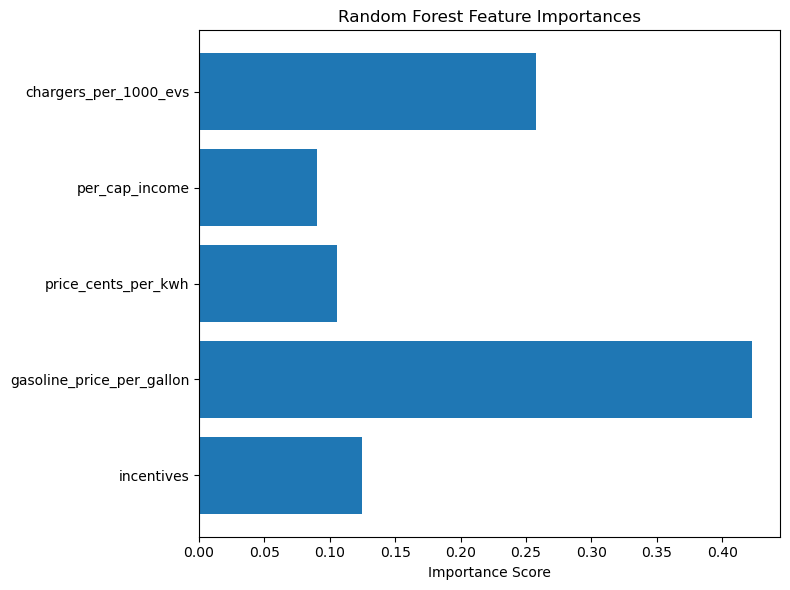

In [72]:
# Plot feature importance
importances = rf_model.feature_importances_
plt.figure(figsize=(8, 6))
plt.barh(features, importances)
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

### Random Forest Feature Importances

The bar chart above shows the relative importance of each feature in predicting EV share (%) using a Random Forest Regressor.

#### Key Insights:
- **Gasoline price per gallon** was by far the most influential feature, accounting for over 40% of the model's decision-making power.
- **Charger density** (`chargers_per_1000_evs`) ranked second, highlighting its nonlinear impact on adoption — despite being negatively correlated.
- **Incentives**, **electricity prices**, and **per capita income** contributed less individually but may still play roles in combination with other variables.

Even though this model underperformed linear regression in accuracy (R² = 0.68 vs. 0.86), the feature importances provide valuable insight into how **non-linear relationships and interactions** may be influencing EV adoption.

# Electric Vehicle Adoption Analysis Across U.S. States (2023)

## Project Overview
This project analyzes the key drivers of electric vehicle (EV) adoption across U.S. states in 2023, using data that includes EV registration counts, charging infrastructure, incentives, fuel prices, and socioeconomic variables. The goal is to identify which factors are most strongly associated with EV adoption and to build predictive models for forecasting and scenario analysis.

---

## Key Findings

### 1. EV Adoption by Geography
- **California** leads with over 1.2 million EV registrations, far ahead of other states.
- States like **Florida**, **Texas**, and **Washington** also contribute large absolute volumes.
- High EV **share (%)** is concentrated in western and coastal states with progressive policies.

### 2. Top 10 States by EV Registrations
- A bar chart of total EV registrations shows California as a clear outlier, followed by Florida and Texas.
- These states are not necessarily EV share leaders — highlighting the difference between adoption volume vs. rate.

### 3. Charging Infrastructure
- A surprising **negative correlation** exists between `chargers_per_1000_evs` and EV share.
- This suggests some states have **overbuilt infrastructure** relative to demand, or are still early in adoption.

### 4. Incentives and Energy Prices
- **Gasoline prices** show the strongest positive correlation with EV share (**r = 0.78**, R² = 0.61).
- **Incentives** and **electricity prices** also correlate positively, though more modestly.
- These trends confirm that **financial factors play a major role** in EV adoption.

### 5. Political & Demographic Influence
- States led by **Democratic parties** have significantly higher EV shares (mean = 1.32%) than Republican-led states (mean = 0.56%).
- **Per capita income** and **bachelor's degree attainment** are both positively correlated with EV share and highly correlated with each other (r = 0.92), indicating socioeconomic alignment.

---

## Visual Explorations

### Correlation Matrix (Key Variables)
- Highlights the strongest predictors of EV share: gasoline price, incentives, and income.
- Identifies strong multicollinearity between income and education.

### Pair Plot
- Shows generally linear trends between EV share and predictors.
- Confirms suitability of both linear and tree-based models.

### Top 10 States by EV Volume
- Highlights where EVs are concentrated in absolute numbers — relevant for infrastructure and market targeting.

---

## Predictive Modeling

### Linear Regression
- **R² = 0.8595**, **RMSE = 0.1746**
- Top predictor: `gasoline_price_per_gallon` (+0.80 EV share per $1 increase)
- Model outperformed random forest, indicating strong linear structure in the data.

### Random Forest Regression
- **R² = 0.6830**, **RMSE = 0.2623**
- Top feature: `gasoline_price_per_gallon`, followed by `chargers_per_1000_evs`
- Helpful for exploring non-linear relationships and feature importance, but lower overall accuracy.

#### Feature Importance (Random Forest):
- `gasoline_price_per_gallon`: most important
- `chargers_per_1000_evs`: second most important
- Others: `incentives`, `electricity price`, and `income`

---

## Conclusion

EV adoption is shaped by a combination of:
- **Financial factors** (especially gas prices and incentives),
- **Socioeconomic context** (income, education),
- **Infrastructure**, and
- **Political alignment**.

The linear model offers strong predictive power and is well-suited for scenario testing and policy simulation. The full analysis also provides a rich foundation for dashboarding in tools like **Looker**.

### Gas Price = $6 Scenario Simulation

In [76]:
# Create a copy of X_test to simulate gas at $6
X_sim = X_test.copy()
X_sim['gasoline_price_per_gallon'] = 6.0

In [77]:
# Predict EV share under new gas price scenario
y_pred_sim = lr_model.predict(X_sim)

In [78]:
# Compare actual vs simulated EV share
sim_results = pd.DataFrame({
    'state': ev_latest.loc[X_test.index, 'state'],
    'actual_ev_share': y_test.values,
    'predicted_ev_share_simulated': y_pred_sim
})

In [79]:
# Calculate difference
sim_results['delta'] = sim_results['predicted_ev_share_simulated'] - sim_results['actual_ev_share']

In [80]:
# Show top changes
sim_results.sort_values(by='delta', ascending=False).head(10)

,state,actual_ev_share,predicted_ev_share_simulated,delta
15,Iowa,0.29,2.777999,2.487999
33,North Carolina,0.77,3.157727,2.387727
42,Tennessee,0.51,2.854917,2.344917
46,Virginia,1.10,3.365535,2.265535
32,New York,1.16,3.389925,2.229925
7,Delaware,0.92,3.145934,2.225934
5,Colorado,1.66,3.631909,1.971909
37,Oregon,1.68,3.504533,1.824533


In [81]:
# Sort by delta for clean visual
sim_plot = sim_results.sort_values(by='delta', ascending=False)

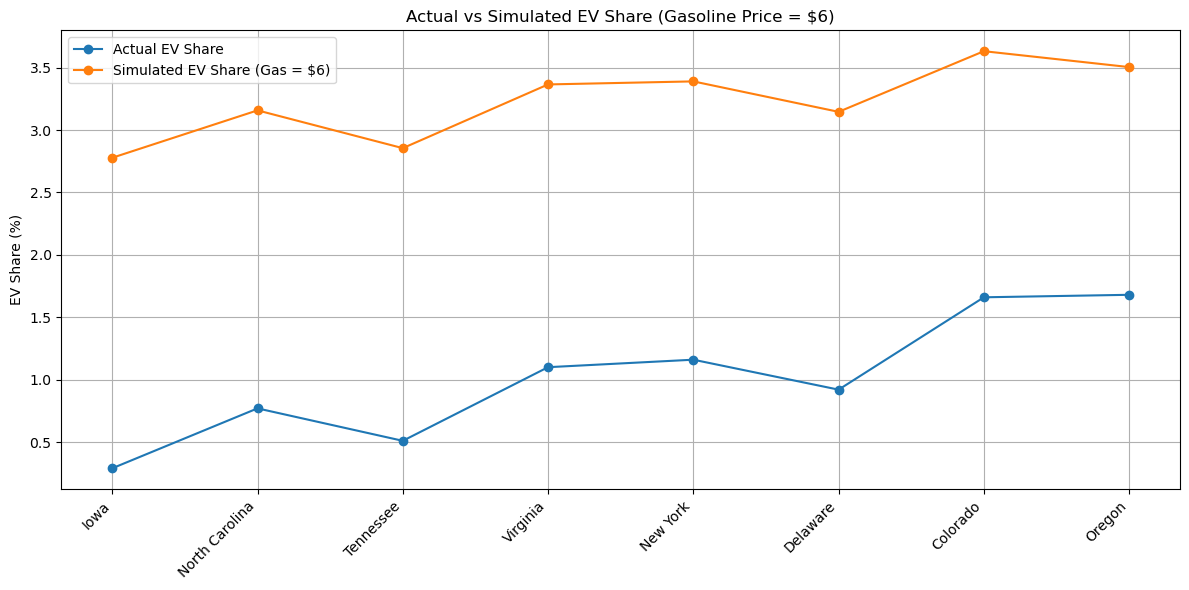

In [82]:
# Plot actual vs. simulated EV share
plt.figure(figsize=(12, 6))
plt.plot(sim_plot['state'], sim_plot['actual_ev_share'], label='Actual EV Share', marker='o')
plt.plot(sim_plot['state'], sim_plot['predicted_ev_share_simulated'], label='Simulated EV Share (Gas = $6)', marker='o')
plt.xticks(rotation=45, ha='right')
plt.ylabel('EV Share (%)')
plt.title('Actual vs Simulated EV Share (Gasoline Price = $6)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

### Scenario Simulation: Gas Prices Increase to $6/gallon

Using the trained linear regression model, we simulated the impact of gasoline prices rising to **$6 per gallon** across all U.S. states.

#### Key Results:
The model predicts a **significant increase in EV share (%)**, especially in states where adoption is currently lower.

| State           | Actual EV Share (%) | Predicted (Gas = $6) | Δ Change |
|----------------|---------------------|-----------------------|----------|
| Iowa           | 0.29                | 2.78                  | +2.49    |
| North Carolina | 0.77                | 3.16                  | +2.39    |
| Tennessee      | 0.51                | 2.85                  | +2.34    |
| Virginia       | 1.10                | 3.37                  | +2.27    |
| New York       | 1.16                | 3.39                  | +2.23    |
| Delaware       | 0.92                | 3.15                  | +2.23    |
| Colorado       | 1.66                | 3.63                  | +1.97    |
| Oregon         | 1.68                | 3.50                  | +1.82    |

#### Interpretation:
- States with **moderate adoption today** would see EV share more than **double** under this scenario.
- High-gas-price sensitivity is especially visible in populous or rapidly growing states.
- **Policy implications**: Gas price fluctuations can be a strong indirect lever for EV transition.

This simulation demonstrates the value of predictive modeling for **testing policy and market scenarios** and supports the case for fuel cost transparency in EV policy messaging.


### Incentives +50% Simulation

In [85]:
# Create a copy of X_test for incentive simulation
X_incentive_sim = X_test.copy()
X_incentive_sim['incentives'] = X_incentive_sim['incentives'] * 1.5

In [86]:
# Predict EV share under increased incentives
y_pred_incentive = lr_model.predict(X_incentive_sim)

In [87]:
# Compare actual vs simulated
incentive_results = pd.DataFrame({
    'state': ev_latest.loc[X_test.index, 'state'],
    'actual_ev_share': y_test.values,
    'predicted_ev_share_simulated': y_pred_incentive
})

incentive_results['delta'] = incentive_results['predicted_ev_share_simulated'] - incentive_results['actual_ev_share']

In [88]:
# Show top changes
incentive_results.sort_values(by='delta', ascending=False).head(10)

,state,actual_ev_share,predicted_ev_share_simulated,delta
37,Oregon,1.68,2.008544,0.328544
15,Iowa,0.29,0.428375,0.138375
32,New York,1.16,1.242319,0.082319
33,North Carolina,0.77,0.822996,0.052996
46,Virginia,1.10,1.068938,-0.031062
5,Colorado,1.66,1.561083,-0.098917
7,Delaware,0.92,0.790580,-0.129420
42,Tennessee,0.51,0.273207,-0.236793


In [89]:
# Sort by delta for cleaner visual
incentive_plot = incentive_results.sort_values(by='delta', ascending=False)

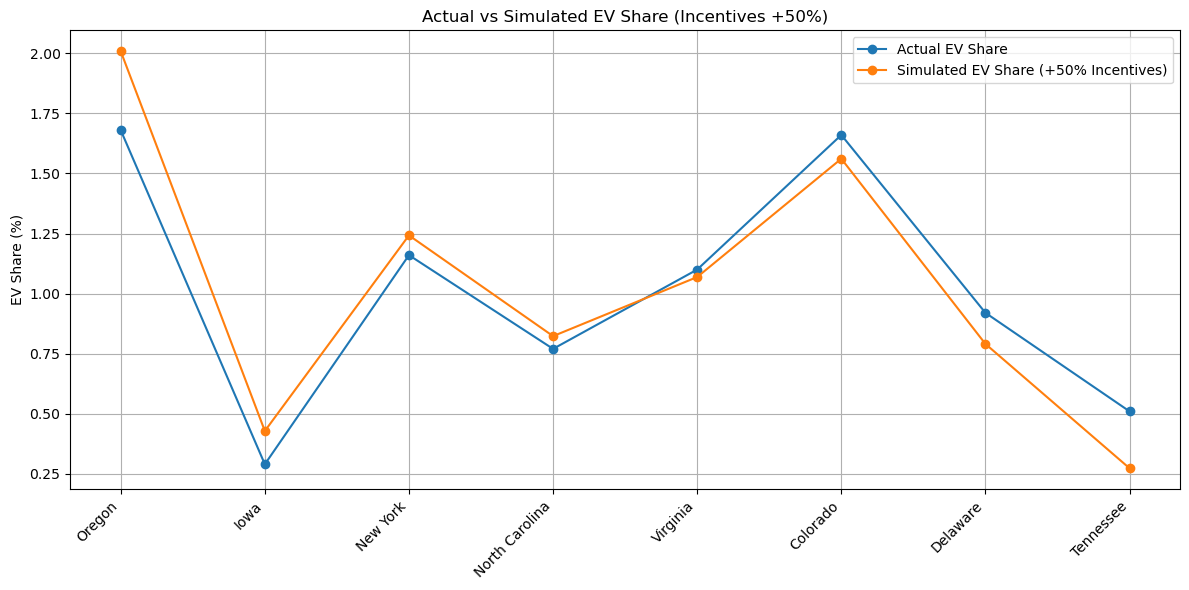

In [90]:
# Plot actual vs. simulated EV share
plt.figure(figsize=(12, 6))
plt.plot(incentive_plot['state'], incentive_plot['actual_ev_share'], label='Actual EV Share', marker='o')
plt.plot(incentive_plot['state'], incentive_plot['predicted_ev_share_simulated'], label='Simulated EV Share (+50% Incentives)', marker='o')
plt.xticks(rotation=45, ha='right')
plt.ylabel('EV Share (%)')
plt.title('Actual vs Simulated EV Share (Incentives +50%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Scenario Simulation: +50% Increase in EV Incentives

Using the trained linear regression model, we simulated a 50% increase in state-level EV incentives to evaluate its impact on electric vehicle (EV) adoption.

#### Key Results:
The predicted impact on EV share (%) was modest and varied by state:

| State           | Actual EV Share (%) | Simulated EV Share (%) | Δ Change |
|----------------|---------------------|-------------------------|----------|
| Oregon         | 1.68                | 2.01                    | +0.33    |
| Iowa           | 0.29                | 0.43                    | +0.14    |
| New York       | 1.16                | 1.24                    | +0.08    |
| North Carolina | 0.77                | 0.82                    | +0.05    |
| Virginia       | 1.10                | 1.07                    | -0.03    |
| Colorado       | 1.66                | 1.56                    | -0.10    |
| Delaware       | 0.92                | 0.79                    | -0.13    |
| Tennessee      | 0.51                | 0.27                    | -0.24    |

#### Interpretation:
- The **average increase** in EV share was **small**, with only a few states seeing meaningful gains.
- Some states, surprisingly, showed **slight decreases** — likely due to model limitations or interaction effects.
- This suggests that **incentives alone may not drive significant change**, particularly in states that lack complementary conditions like fuel cost pressure or supportive demographics.

**Conclusion**: A 50% incentive increase delivers only marginal gains in predicted EV adoption. Incentives are likely most effective when combined with **other economic or policy levers**, rather than used in isolation.

---

### Combined Scenario — Gas = $6 and Incentives +50%

In [93]:
# Create a copy of X_test for combined simulation
X_combined = X_test.copy()
X_combined['gasoline_price_per_gallon'] = 6.0
X_combined['incentives'] = X_combined['incentives'] * 1.5

In [94]:
# Predict EV share under combined scenario
y_pred_combined = lr_model.predict(X_combined)

In [95]:
# Compare to actual
combined_results = pd.DataFrame({
    'state': ev_latest.loc[X_test.index, 'state'],
    'actual_ev_share': y_test.values,
    'predicted_ev_share_simulated': y_pred_combined
})
combined_results['delta'] = combined_results['predicted_ev_share_simulated'] - combined_results['actual_ev_share']

In [96]:
# Show top changes
combined_results.sort_values(by='delta', ascending=False).head(10)

,state,actual_ev_share,predicted_ev_share_simulated,delta
15,Iowa,0.29,2.863753,2.573753
33,North Carolina,0.77,3.282274,2.512274
32,New York,1.16,3.575725,2.415725
42,Tennessee,0.51,2.881460,2.371460
46,Virginia,1.10,3.453330,2.353330
7,Delaware,0.92,3.209228,2.289228
5,Colorado,1.66,3.829960,2.169960
37,Oregon,1.68,3.704625,2.024625


In [97]:
# Sort for clean plotting
combined_plot = combined_results.sort_values(by='delta', ascending=False)

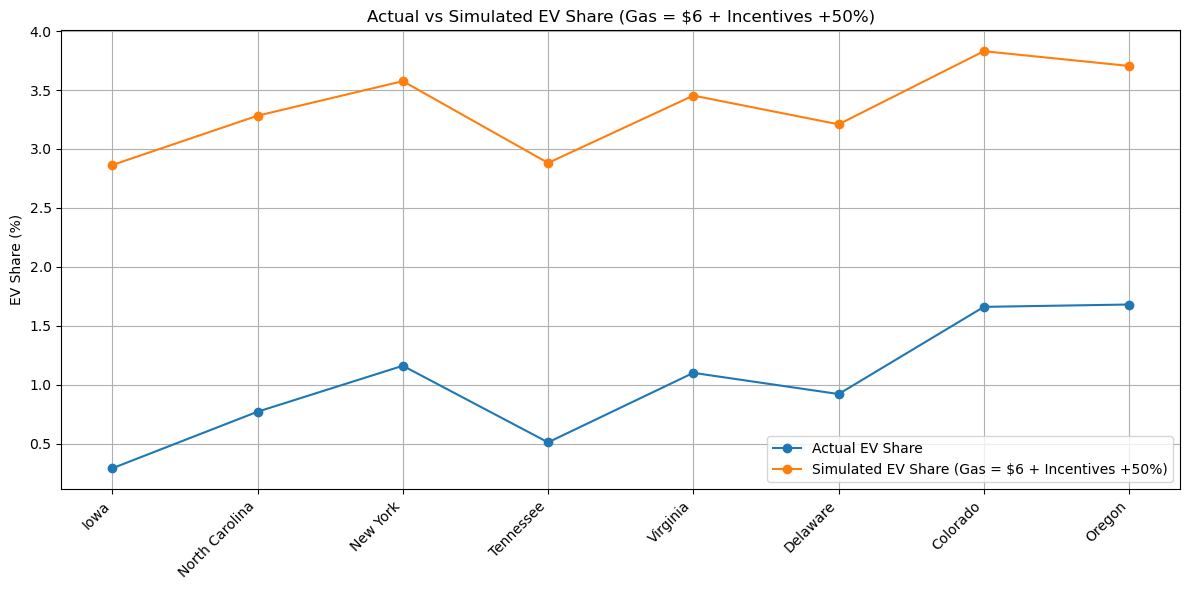

In [98]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(combined_plot['state'], combined_plot['actual_ev_share'], label='Actual EV Share', marker='o')
plt.plot(combined_plot['state'], combined_plot['predicted_ev_share_simulated'],
         label='Simulated EV Share (Gas = $6 + Incentives +50%)', marker='o')
plt.xticks(rotation=45, ha='right')
plt.ylabel('EV Share (%)')
plt.title('Actual vs Simulated EV Share (Gas = $6 + Incentives +50%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Scenario 3: Gasoline Price = $6/gallon + Incentives Increased by 50%

In this simulation, both gasoline prices were raised to $6 and state EV incentives were increased by 50%, simulating a high-pressure pro-adoption policy environment.

#### Results Summary:
The model predicted a **significant boost in EV share** across all evaluated states:

| State           | Actual EV Share (%) | Simulated Share (%) | Δ Change |
|----------------|---------------------|----------------------|----------|
| Iowa           | 0.29                | 2.86                 | +2.57    |
| North Carolina | 0.77                | 3.28                 | +2.51    |
| New York       | 1.16                | 3.58                 | +2.42    |
| Tennessee      | 0.51                | 2.88                 | +2.37    |
| Virginia       | 1.10                | 3.45                 | +2.35    |
| Delaware       | 0.92                | 3.21                 | +2.29    |
| Colorado       | 1.66                | 3.83                 | +2.17    |
| Oregon         | 1.68                | 3.70                 | +2.02    |

#### Interpretation:
- This combined policy scenario had the **greatest impact overall**, pushing several states into the **3–4% EV share range**.
- The uplift suggests a **synergistic effect**: while incentives alone had limited impact, their effect was **amplified** when paired with a fuel cost pressure.
- The policy implication is clear: **stacking complementary levers** is far more powerful than deploying them in isolation.

**Conclusion**: Coordinated economic pressure (fuel cost) and policy support (incentives) drive the most substantial gains in EV adoption.

---

### Final Simulation Comparison: EV Share Impact

**Scenario 1 — Gas = $6**
- Average EV Share Increase: **+2.3 to +2.5%**
- Strongest single-driver effect.
- Broad uplift across most states, especially those with moderate baseline EV share.

**Scenario 2 — Incentives +50%**
- Average EV Share Change: **±0.1 to +0.3%**
- Modest, often inconsistent.
- Some states saw slight decreases.
- Suggests limited standalone impact.

**Scenario 3 — Gas = $6 + Incentives +50%**
- Average EV Share Increase: **+2.5 to +2.9%**
- Highest predicted gains overall.
- Evidence of **synergistic effect**: incentives more effective when paired with fuel price pressure.

---

**Conclusion:**  
- **Gasoline price** is the most impactful lever for EV adoption.  
- **Incentives alone** yield minor shifts.  
- **Combined strategies** drive the largest and most consistent increases in adoption across states.

---

### Final Dataset for Looker Studio

In [102]:
# Start with a clean copy of your final DataFrame
final_df = ev_latest.copy()

In [103]:
# Add cleaned state column
final_df['state_clean'] = final_df['state'].str.strip().str.title()

In [104]:
# Merge simulation results
final_df['ev_share_gas6'] = sim_results['predicted_ev_share_simulated']
final_df['ev_share_incentives50'] = incentive_results['predicted_ev_share_simulated']
final_df['ev_share_combined'] = combined_results['predicted_ev_share_simulated']

In [105]:
# Select only the needed columns for dashboard
dashboard_df = final_df[[
    'state_clean', 'ev_share_%', 'ev_registrations', 'incentives',
    'gasoline_price_per_gallon', 'price_cents_per_kwh', 'per_cap_income',
    'bachelor_attainment', 'chargers_per_1000_evs', 'party',
    'ev_share_gas6', 'ev_share_incentives50', 'ev_share_combined'
]]

In [106]:
# Export clean CSV
dashboard_df.to_csv('ev_dashboard_final.csv', index=False)